Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 3 Clustering

#### Load Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import time
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## Section 1: Business Understanding 1

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

...

## Section 2: Data Understanding 1

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

### Sub-Section 2.1: Load Data

#### Read in data

In [2]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### Create Show Variable

In [3]:
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


### Sub-Section 2.2: Describe the Data

In [4]:
#First column (index 0) hidden because it represents the physical row location and doesn't have contextual meaning
print('Data File Shape:', runs_df.iloc[:,1:].shape,'\n')
runs_df.iloc[:,1:].info()
runs_df.iloc[:,1:].describe()

Data File Shape: (79423, 29) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   race_id          79423 non-null  int64  
 1   horse_no         79423 non-null  int64  
 2   horse_id         79423 non-null  int64  
 3   result           79423 non-null  int64  
 4   won              79423 non-null  float64
 5   lengths_behind   79423 non-null  float64
 6   horse_age        79423 non-null  int64  
 7   horse_country    79423 non-null  object 
 8   horse_type       79423 non-null  object 
 9   horse_rating     79423 non-null  int64  
 10  horse_gear       79423 non-null  object 
 11  declared_weight  79423 non-null  float64
 12  actual_weight    79423 non-null  int64  
 13  draw             79423 non-null  int64  
 14  position_sec1    79423 non-null  int64  
 15  position_sec2    79423 non-null  int64  
 16  position_sec3    79423 non-

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
count,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,...,79423.000000,79423.00000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000
mean,3173.954132,6.905644,2204.346159,6.837050,0.080078,5.858119,3.339461,61.035103,1104.952609,122.730091,...,4.246243,21.12304,22.916673,23.850489,85.325614,28.806138,7.421841,79.794379,85.832983,0.240069
std,1832.807523,3.760600,1275.090631,3.729836,0.271415,29.721938,0.876864,11.750531,62.350596,6.305551,...,3.482293,5.99998,0.982845,0.877137,18.511937,30.093854,8.613459,45.118550,54.338459,0.427128
min,0.000000,1.000000,0.000000,1.000000,0.000000,-0.500000,2.000000,10.000000,693.000000,103.000000,...,0.000000,12.39000,19.990000,21.000000,55.160000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1587.000000,4.000000,1085.000000,4.000000,0.000000,1.750000,3.000000,60.000000,1062.000000,118.000000,...,1.750000,14.12000,22.290000,23.230000,70.590000,7.700000,2.400000,47.000000,39.000000,0.000000
50%,3175.000000,7.000000,2209.000000,7.000000,0.000000,4.000000,3.000000,60.000000,1102.000000,123.000000,...,3.750000,24.18000,22.870000,23.760000,83.350000,15.000000,4.400000,75.000000,76.000000,0.000000
75%,4765.000000,10.000000,3308.000000,10.000000,0.000000,6.750000,3.000000,60.000000,1146.000000,128.000000,...,5.750000,25.36000,23.520000,24.410000,100.780000,38.000000,8.200000,118.000000,138.000000,0.000000
max,6348.000000,14.000000,4404.000000,14.000000,1.000000,999.000000,10.000000,138.000000,1369.000000,133.000000,...,206.750000,33.20000,27.410000,54.950000,163.580000,99.000000,101.000000,175.000000,185.000000,1.000000


The data file contains 29 attributes (28 provided and 1 created) and 79,423 instances. The response variable for our classifications will be the 'Won' attribute. The descriptive statistics for each predictor are listed above. We do not see any missing values or any values outside of a reasonable range of outcomes. Therefore, we do not need to impute any missing values or evaluate trimming instances with outlier values.

First, we will describe the response variable we are focused on classifying.

Response Variable:
- Won: a boolean value where 1 indicates the horse finished first in the race and 0 indicates the horse did not. A horse with a Result of 1 will have a Won response of 1. All others will have a Won response of 0.

Next, we will trim down features that leak information about the response variable, and remove features that don't provide useful insight based on our team's domain knowledge and previous investigations.

Features to be removed because they leak information about the outcome that would not normally be available before a race:
- result: finishing position of this horse in the race
- lengths_behind: finishing position, as the number of horse lengths behind the winner
- position_sec1/2/3: position of this horse (ranking) in section 1/2/3 of the race
- behind_sec1/2/3: position of this horse (lengths behind leader) in section 1/2/3 of the race
- time1/2/3: time taken by the horse to pass through the 1st/2nd/3rd section of the race (sec)
- finish_time: finishing time of the horse in this race (sec)
- Show: a boolean value where 1 indicates the horse placed in the top 3 of the race and 0 indicates the horse did not. A horse with a Result of 1, 2, or 3 will have a Show response of 1. All others will have a Show response of 0.
    - Show is the one created variable that is included with the initial data because it is a common wager placed by horse racing gamblers

Features to be removed because they do not provide sufficient insight about the response:
- race_id: unique identifier for the race
- horse_id: unique identifier for this horse
- horse_gear: string representing the gear carried by the horse in the race. An explanation of the codes used may be found on the HKJC website
- trainer_id: unique identifier of the horse's trainer at the time of the race
- jockey_id: unique identifier of the jockey riding the horse in this race

Now, we will define the remaining continuous and categorical features that will be used to create clusters and classify the response. The 2 categorical features will be one-hot encoded where each categorical level will become a binary feature with outcomes of 0 or 1. This will result in 8 continuous features and 25 binary features remaining. Due to the variance of scale in the remaining features, our team will use a MinMax Scaler before classification. This scales each feature based on the relative position of each value between the min and max values of the feature. During this scaling, we will ensure we limit data leakage by fitting the scale to the training data and transforming both the training and testing data based on the fit.

Continuous features:
- Horse_no: the number assigned to this horse, in the race
- Horse_age: all horses in the data set are 2, 3, 4, 5, 6, 7, 8, 9, or 10 years old at the time of race. The average age of horses in the dataset is 3.3 years
- Horse_rating - rating number assigned by HKJC to this horse at the time of the race
- Declared_weight: floating point value for the weight of the horse, the jockey, and the equipment in pounds.
- Actual_weight: integer value for the weight the horse carried; i.e. the weight of the Jockey and equipment
- Draw - post position number of the horse in this race
- Win_odds: floating point value for the odds of the horse to win the race
- Place_odds: floating point value for the odds of the horse to place in 1st, 2nd, or 3rd

Categorical features that will be one-hot encoded:
- Horse_country: a country code for the country of origin for the horse. Examples are NZ, AUS, USA
- Horse_type: examples are gelding, mare, rig

### Sub-Section 2.3: Remove uneeded features and one-hot encode categorical data

#### Remove variables that are not needed/useful for the analysis

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']

print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


#### One-Hot Encode Categorical Variables

In [5]:
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Section 3: Data Understanding 2

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

...

#### Win Odds and Horse Country

The following graph plots the country of origin for the horse and it's win odds. There is some relationship between a horse's country of origin and it's win odds. Particularly, horses from Australia and Ne Zealand tend to have really good odds. Horses from Canada, Italy, Argentina tend to have lower odds but also a wider distribution.

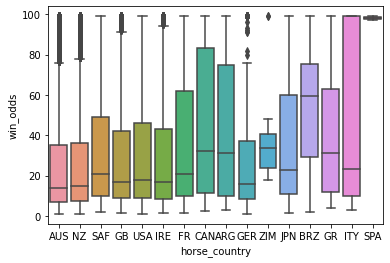

In [6]:
sns.boxplot(x="horse_country",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Horse Type

Next, we looked at horse type, which based on previous labs tended to be an important feature. Geldings, Browns, and Greys had smaller distributions of win odds. Geldings had the best odds on average. Ris, Colts, and Fillys would be less sure bets based on the distribution of odds for those types of horses.

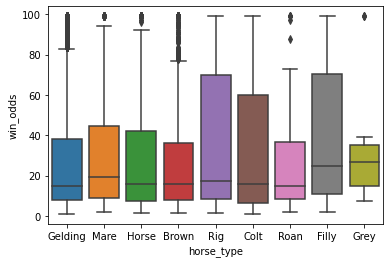

In [7]:
sns.boxplot(x="horse_type",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Finish Place

Based on previous labs, far and away the most important feature in determining a result was the horse's win odds. The graph below plots that relationship. As can be seen, there is a strong relationship. Horses with better odds were not only more likely to win (based on mean) but had much smaller distributions. Intuitively, this makes sense. Horse odds are set by professionals who have the best information and insight into the chances a horse will win a particular race.

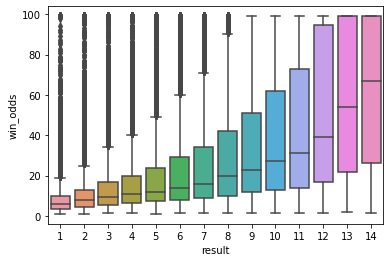

In [12]:
sns.boxplot(x='result', y='win_odds', data=runs_df)
plt.show()

#### Place Odds and Finish Position

Similarly to win odds, we plotted place odds against result. As would be expected, the relationship is very similar to win odds. In fact the range of distribution is smaller. That makes sense since win is determined by a horse finishing in a single position (1) whereas place is the horse finishing in first through third, so it is more forgiving. 

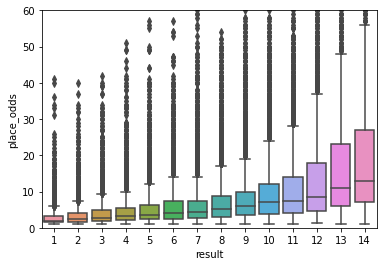

In [13]:
sns.boxplot(x='result', y='place_odds', data=runs_df)
plt.ylim(0,60)
plt.show()

#### Draw and Finish Position

The draw of a horse is random. Which horse begins the race in which stall is not determined by win odds or any other factor. It's a well known fact in racing that the "inside" track is preferred since it reduces the overall distance you have to travel. Therefore it intuitively makes sense that a horse beginning the race inside (draw 1) would have a slightly better chance in the race.

The chart below backs this up, to an extent. It is clear that the higher draw a hhorse has (the further from pole position they begin), the worse result they have on average.

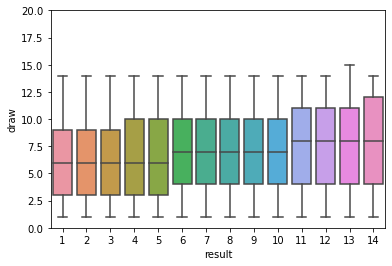

In [24]:
sns.boxplot(x='result', y='draw', data=runs_df)
plt.ylim(0,20)
plt.show()

#### Win Odds vs Result with Confidence Interval

Since it is clear there is a strong relationship between a horse's win or place odds and their result, we took another look at that relationship in another way.

The two plots below show the linear relationship between win odds an result, and place odds and result, with confidence intervals. Note how small he intervals. As the odds for a horse get worse, the interval gets larger, but only slightly. 

<AxesSubplot:xlabel='result', ylabel='win_odds'>

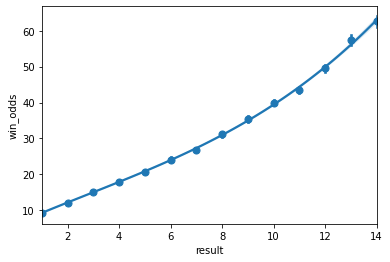

In [16]:
sns.regplot(x="result", y="win_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Place Odds vs Result with Confidence Interval

Refer to the description above.

<AxesSubplot:xlabel='result', ylabel='place_odds'>

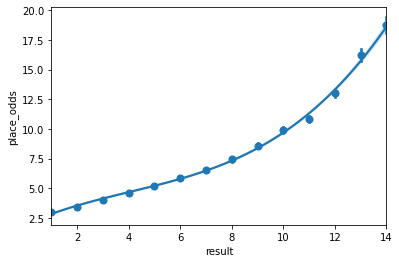

In [17]:
sns.regplot(x="result", y="place_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Draw vs Result with Confidence Interval

Again, we plotted the linear relationship. This time between draw and result. We showed earlier their is a relationship between draw and result, but you could see it was not as strong as the relationship between win or place odds and result.

The confidence intervals for the below plot support the claim that the relationship is not as strong. The confidence intervals are not nearly as tight, meaning their is a wider distribution. So, the draw is an important feature in result, but it is not as much of a "sure thing" as win or place odds.

<AxesSubplot:xlabel='result', ylabel='draw'>

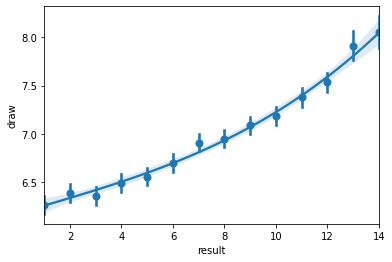

In [22]:
sns.regplot(x="result", y="draw", data=runs_df, x_estimator=np.mean, order=3)

#### Win Odds vs Place Odds, by Result

The last plot we chose to include in this report is a scatterplot showing win odds vs. place odds, categorized by result. The lighter the color, the better result, or finishing position. The darker the color, the worse the result.

It is clear, on the bottom-left of the graph the data points are lighter. In other words, a horse with lower win and place odds tends to finish the race in a better position. 

For this we filtered the data set for place odds of less than 30:1. There are a large number of outliers that make the plot less clear to read. We included the unfiltered plot below, for reference.

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

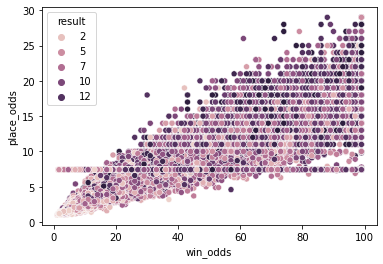

In [45]:
runs_df_lower_odds = runs_df[runs_df['place_odds'] < 30] 
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df_lower_odds)

#### Same plot but unfiltered for outliers

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

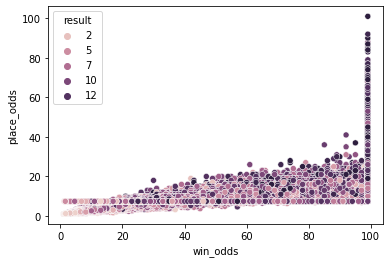

In [46]:
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df)

## Section 4: Modeling and Evaluation 1

Train and adjust parameters

...

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    init='k-means++', # initialization
    n_clusters=10,    # number of clusters
    n_init=3,         # number of different times to run k-means
    n_jobs=-1)

kmeans.fit(X_train)

yhat= kmeans.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat,average='micro')
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

print('Precision is: %.3f'%(prec), ' AUC: %.3f'%auc)

Precision is: 0.118  AUC: 0.547


### Sub-Section 4.2 DBSCAN

DBSCAN is a density based clustering algrithim. Our team will compare 3 Random Forest classification models to predict 'Won'. The first is a reference model that was found to be the best model from Lab 2 and does not use clustering. The second will use a DBSCAN cluster of manually selected attributes and include this in the model along with the other key attributes. The third model will use a DBSCAN cluster of the top 3 Principal Components and include this in the model along with the other key attributes. Our focus is on maximizing precision and our secondar metric of importance is AUC. The reason we are limiting each of these methods to 3 features is that it will allow us to visualize our results. DBSCAN is capable of clustering in higher dimensions even though that may not be a strength of the algorithim.

#### Sub-Section 4.2.1 Base Random Forest Model (from Lab 2) for Reference

This model and associated parameters were optimized in Lab 2 to predict won acheived the highest precision and AUC. We will select the balanced option, use 64 trees, and have a maximum tree depth of 100.

#### Load test/train data set

In [42]:
#train test split won
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

#### Look at Random Forest model example without clustering with all variables included (parameters optimized based on Lab 2 investigation)

In [43]:
rf=RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
rf.fit(X_train, Y_train)
yhat=rf.predict(X_test)

Random Forest without clustering with all variables:
   Precision:  0.5294117647058824
   AUC:  0.50990233914883


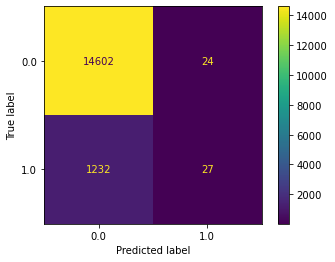

In [44]:
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Random Forest without clustering with all variables:')
print('   Precision: ',prec)
print('   AUC: ',auc)
plot_confusion_matrix(rf, X_test, Y_test)

The random forest model using no clusters and all the features results in a Precision of 0.529 and an AUC of 0.510.

#### Sub-Section 4.2.2 DBSCAN Cluster With Manual Feature Selection

Next, we will use the visuals from the data understanding section and domain knowledge to select draw, win odds, and place odds as the three most influential features in predicting won. We will use DBSCAN to cluster these features and use the clusters as an additional attribute to predict Won.

#### Find specified nearest neighbor distance to find appropriate value for EPS

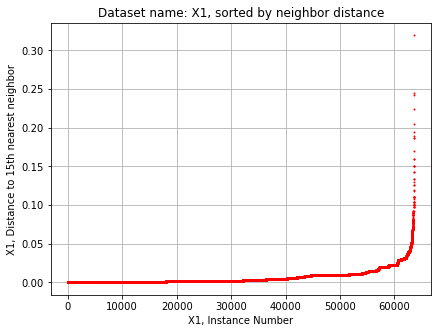

In [122]:
draw_win_place_train=X_train[:,[5,6,7]] #Create an array with win odds, place odds, and horse age
X1=draw_win_place_train

#=======================================================
# CHANGE THIS VALUES TO ADJUST MINPTS FOR THE DATASET
X1_N = 15
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1, X1_N, mode='distance') # calculate distance to four nearest neighbors 

N1 = X1_knn_graph.shape[0]
X1_4nn_distances = np.zeros((N1,1))
for i in range(N1):
    X1_4nn_distances[i] = X1_knn_graph[i,:].max()

X1_4nn_distances = np.sort(X1_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N1), X1_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X1, sorted by neighbor distance')
plt.xlabel('X1, Instance Number')
plt.ylabel('X1, Distance to {0}th nearest neighbor'.format(X1_N))
plt.grid()

This plot shows the sorted distance of the 15th nearest neighbor for each instance of the data set with draw, win odds, and place odds. Setting the eps parameter based on the distance at the elbow of the chart above, we used an eps of .029 and min points of 15 for our DBSCAN model.

#### Find clusters based on training data using DBSCAN

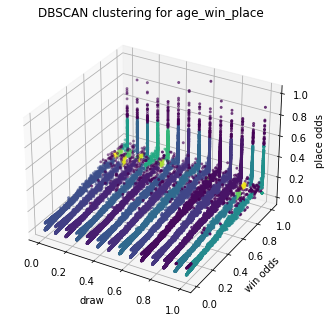

number of clusters found:  39


In [123]:
X=X1
X_minpts = 15 # from above
X_eps = 0.029

model = DBSCAN(eps=X_eps, min_samples=X_minpts)
pred = model.fit_predict(X)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=model.labels_, s=4,depthshade=True)
plt.title('DBSCAN clustering for age_win_place')
plt.xlabel('draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

print("number of clusters found: ", len(set(model.labels_)))

In [125]:
silhouette_score(X,pred,random_state=0)

-0.02556027740584741

A visual of the clustered data from the training set is shown above. The model sorted the data into 39 clusters. Many of the clusters appear to make sense visually. In addition to visual verification, we will use the silhouette score which uses a scale from -1 (worst) to 1 (best) to describe the intra-cluster distance. When looking at the silhouette score, we have a value near zero that drifts slightly negative. This is an indicator there are overlapping clusters which is not ideal.

Further information on the silhouette score can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

#### Find clusters for test data using KNN

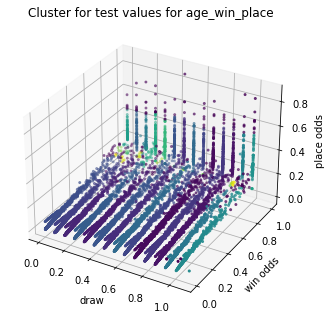

number of cluster found:  39


In [126]:
X1_test=X_test[:,[5,6,7]]

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X1,model.labels_)
y_pred=neigh.predict(X1_test)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X1_test[:,0], X1_test[:,1], X1_test[:,2], c=y_pred, s=4,depthshade=True)
plt.title('Cluster for test values for age_win_place')
plt.xlabel('draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

print("number of cluster found: ", len(set(y_pred)))

To prevent data leakage, the initial clusters were created with training data only. We are able to approximate the cluster each test data point belongs to by using KNN to predict the cluster value based on the training cluster values. Above, is a visual plot of the test data sorted into clusters. It appears to match the pattern from the training data, so we can be confident the KNN method to predict clusters for test points was effective.

#### Add one-hot encoded clusters to the training and test sets

We will now one-hot encode the clusters as they are a nominal attribute. This will allow us to use the clusters to predict Won.

In [127]:
one_hot_labels = np.zeros((model.labels_.size, model.labels_.max()+1))
one_hot_labels[np.arange(model.labels_.size),model.labels_] = 1
#print(one_hot_labels.shape)

one_hot_preds = np.zeros((y_pred.size, y_pred.max()+1))
one_hot_preds[np.arange(y_pred.size),y_pred] = 1
#print(one_hot_preds.shape)

new_xtrain=np.hstack((X_train, one_hot_labels))
new_xtest=np.hstack((X_test, one_hot_preds))

#### Predict Won with new cluster attributes

We now will use a random forest model that includes the cluster as an additional feature with the same parameters as the reference model. This will allow us to compare the impact of the cluster attribute on the model.

In [128]:
rf=RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
rf.fit(new_xtrain, Y_train)
yhat=rf.predict(new_xtest)

Random Forest with all variables and DBSCAN clustering attribute:
   Precision:  0.42424242424242425
   AUC:  0.509820879982735


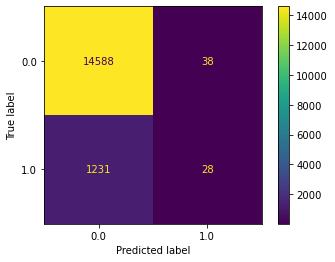

In [129]:
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Random Forest with all variables and DBSCAN clustering attribute:')
print('   Precision: ',prec)
print('   AUC: ',auc)
plot_confusion_matrix(rf, new_xtest, Y_test)

The model has a lower Precision (.42) and AUC (.509) than the reference model so the additional attribute created by clustering the three most significant features draw, win odds, and place odds did not provide any significant additional value.

#### Sub-Section 4.2.3 DBSCAN Cluster With Feature Selection using PCA

Next, we will use PCA to identify the three principal components that describe the most variation. Using these three principal components, we will use DBSCAN to once again assign each point a cluster and use these values as an additional attribute to predict Won. We will compare a random forest model with the new attribute to the reference model using precision and AUC.

#### Identify Top 3 Principal Components

In [130]:
pca = PCA(n_components=3,random_state=0)
pca_X_train=X_train
pca_X_test=X_test
pca.fit_transform(X_train)
pca.transform(X_test)
print(pca.explained_variance_ratio_)

[0.31407038 0.15827638 0.11670845]


We use PCA on the training data set to fit and transform the test and training data sets. The model identified the top three principal components from the training data set. We can see from the output that these three components capture nearly 60% of the variation in the data set.

#### Find specified nearest neighbor distance to find appropriate value for EPS

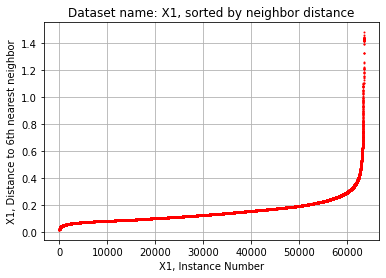

In [133]:
X1=pca_X_train

#=======================================================
# CHANGE THIS VALUES TO ADJUST MINPTS FOR THE DATASET
X1_N = 6
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1, X1_N, mode='distance') # calculate distance to four nearest neighbors 

N1 = X1_knn_graph.shape[0]
X1_4nn_distances = np.zeros((N1,1))
for i in range(N1):
    X1_4nn_distances[i] = X1_knn_graph[i,:].max()

X1_4nn_distances = np.sort(X1_4nn_distances, axis=0)

plt.figure()
plt.plot(range(N1), X1_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X1, sorted by neighbor distance')
plt.xlabel('X1, Instance Number')
plt.ylabel('X1, Distance to {0}th nearest neighbor'.format(X1_N))
plt.grid()

This plot shows the sorted distance of the 6th nearest neighbor for each instance of the data set with the top 3 principal components. Setting the eps parameter based on the distance at the elbow of the chart above, we used an eps of .31 and min points of 6 for our DBSCAN model.

#### Find clusters based on training data using DBSCAN

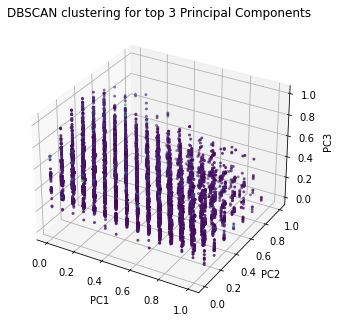

number of clusters found:  50


In [146]:
X=X1
X_minpts = 6 # from above
X_eps = 0.31

model = DBSCAN(eps=X_eps, min_samples=X_minpts)
pred = model.fit_predict(X)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=model.labels_, s=4,depthshade=True)
plt.title('DBSCAN clustering for top 3 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('PC3', rotation=90)
plt.show()

print("number of clusters found: ", len(set(model.labels_)))

In [147]:
silhouette_score(X,pred,random_state=0)

0.459709753380013

Our training data set with 3 principal components was divided into 50 clusters with the DBSCAN algorithm. The plot of the clusters is difficult to interpret and this is likely due to the large amount of the identified noise points. The silhouette score of 0.45 is significantly better than 0 and indicates the clusters are well separated.

#### Find clusters for test data using KNN

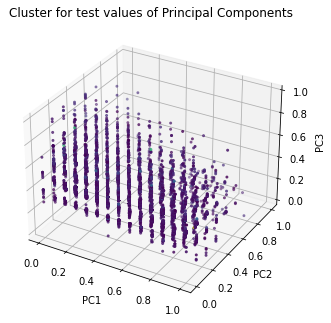

number of cluster found:  47


In [148]:
X1_test=pca_X_test

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X1,model.labels_)
y_pred=neigh.predict(X1_test)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X1_test[:,0], X1_test[:,1], X1_test[:,2], c=y_pred, s=4,depthshade=True)
plt.title('Cluster for test values of Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('PC3', rotation=90)
plt.show()

print("number of cluster found: ", len(set(y_pred)))

We predict the clusters of the test data for the principal components using KNN, and the predicted clusters are plotted above. The plot is difficult to see if the clusters align with the training data. 47 of the 50 clusters appear in the test data. We will assume the cluster predictions are sensible based on the methodology of using KNN.

#### Add one-hot encoded clusters to the training and test sets

We will now one-hot encode the clusters as they are a nominal attribute. This will allow us to use the clusters to predict Won.

In [152]:
one_hot_labels = np.zeros((model.labels_.size, model.labels_.max()+1))
one_hot_labels[np.arange(model.labels_.size),model.labels_] = 1
#print(one_hot_labels.shape)

one_hot_preds = np.zeros((y_pred.size, y_pred.max()+1))
one_hot_preds[np.arange(y_pred.size),y_pred] = 1
#print(one_hot_preds.shape)

new_xtrain=np.hstack((X_train, one_hot_labels))
new_xtest=np.hstack((X_test, one_hot_preds))

#### Predict Won with new cluster attributes

We now will use a random forest model that includes the cluster as an additional feature with the same parameters as the reference model. This will allow us to compare the impact of the cluster attribute on the model.

In [150]:
rf=RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
rf.fit(new_xtrain, Y_train)
yhat=rf.predict(new_xtest)

Random Forest with all variables and DBSCAN PCA clustering attribute:
   Precision:  0.509090909090909
   AUC:  0.5101969226464845


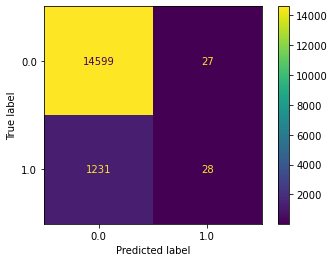

In [151]:
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Random Forest with all variables and DBSCAN PCA clustering attribute:')
print('   Precision: ',prec)
print('   AUC: ',auc)
plot_confusion_matrix(rf, new_xtest, Y_test)

The model has a lower precision at .509 and essentially an identical AUC to the reference model. Therefore, the additional attribute created by clustering the three top principal components did not provide any significant additional value. We can see the model using DBSCAN clustering and PCA outperformed the model using DBSCAN and manual feature selection in our key metric precision. This aligns with what we saw in the silhouette score when comparing these models. The model using PCA had better intra-cluster seperation.

## Section 5: Modeling and Evaluation 2

Evaluate and Compare

...

## Section 6: Modeling and Evaluation 3

Visualize Results

...

## Section 7: Modeling and Evaluation 4

Summarize the Ramifications

...

## Section 8: Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

...

## Section 9: Exceptional Work

You have free reign to provide additional analyses or combine analyses.

...